In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns
import sys
import json

Load scale factors for SHIPS data.  We need to rescale some of the SHIPS predictors as many of them have been scaled up to make their values ints instead of floats. 

In [2]:
with open('/home/mmcgraw/ML_for_TC_RI/SHIPS_factors.txt') as f:
    SHIPS_factors = f.read()
SHIPS_js = json.loads(SHIPS_factors)
#SHIPS_js

Process each basin separately

In [3]:
load_path = '/home/mmcgraw/ML_for_TC_RI/DATA/processed/SHIPS_predictors_full_'
BASIN_all = ['ATLANTIC','EAST_PACIFIC','WEST_PACIFIC','CENTRAL_PACIFIC','SOUTHERN_HEM']
# basin_sel = 'SOUTHERN_HEM'

In [4]:
SHIPS_load = pd.DataFrame()
for basin_sel in BASIN_all:
    fname_load = load_path+'{reg}.csv'.format(reg=basin_sel)
    iSHIPS_load = pd.read_csv(fname_load)
    iSHIPS_load = iSHIPS_load.drop(columns='Unnamed: 0')
    iSHIPS_load['BASIN'] = basin_sel
    SHIPS_load = SHIPS_load.append(iSHIPS_load)

In [5]:
SHIPS_load = SHIPS_load.drop(columns='ATCF ID')

Now, we rescale the SHIPS predictors.  We take the scaling factors from the `json` file we created earlier and divide a given predictor by its scaling factor (assuming it has one; not all predictors have scaling factors). 

In [6]:
col_names = SHIPS_load.columns
for i_col in col_names:
    print('feature is ',i_col)
    if i_col in SHIPS_js.keys():
        print("yay")
        factor = SHIPS_js[i_col][0]
        print('divide by ',factor)
        SHIPS_load[i_col] = SHIPS_load[i_col]/factor
    else:
        print("nay")

feature is  CASE
nay
feature is  NAME
nay
feature is  DATE_full
nay
feature is  TIME
yay
divide by  1
feature is  VMAX
yay
divide by  1
feature is  MSLP
yay
divide by  1
feature is  TYPE
yay
divide by  1
feature is  HIST
yay
divide by  1
feature is  DELV
yay
divide by  1
feature is  INCV
yay
divide by  1
feature is  LAT
yay
divide by  10
feature is  LON
yay
divide by  10
feature is  CSST
yay
divide by  10
feature is  CD20
yay
divide by  1
feature is  CD26
yay
divide by  1
feature is  COHC
yay
divide by  1
feature is  DTL
yay
divide by  1
feature is  OAGE
yay
divide by  10
feature is  NAGE
yay
divide by  10
feature is  RSST
yay
divide by  10
feature is  RSST_AGE
nay
feature is  DSST
yay
divide by  10
feature is  DSST_AGE
nay
feature is  DSTA
yay
divide by  10
feature is  DSTA_AGE
nay
feature is  U200
yay
divide by  10
feature is  U20C
yay
divide by  10
feature is  V20C
yay
divide by  10
feature is  E000
yay
divide by  10
feature is  EPOS
yay
divide by  10
feature is  ENEG
yay
divide by 

In [7]:
flag = 9999
SHIPS_mask = SHIPS_load.mask(SHIPS_load == flag)
SHIPS_mask = SHIPS_mask.mask(SHIPS_mask['TYPE'] != 1)
SHIPS_mask = SHIPS_mask.dropna(how='all')

In [8]:
SHIPS_mask['I_scaled'] = SHIPS_mask['VMAX']/SHIPS_mask['VMPI']
SHIPS_mask['Year'] = pd.to_datetime(SHIPS_mask['DATE_full']).dt.year
SHIPS_mask['Year'] = SHIPS_mask['Year'].astype(int)

In [9]:
SHIPS_rs = SHIPS_mask.set_index(['TIME','BASIN','Year'])

In [10]:
fore_hrs = [24,48,72,96,120]

In [11]:
for ihr in fore_hrs:
    nhr = ihr
    foo = SHIPS_rs.xs(nhr)
    foo = foo.where(foo['VMPI']!=0).dropna(how='all')
    #basin_sel = 'SOUTHERN_HEM'
    for basin_sel in BASIN_all:
        foox = foo.xs(basin_sel)
        fig1,(ax1a,ax1b,ax1c) = plt.subplots(3,1,figsize=(12,10))
        pl1a = sns.kdeplot(data = foox.reset_index(),x='VMAX',hue='Year',palette='twilight',linewidth=4,ax=ax1a)
        sns.set_context('paper', font_scale=1.4)
        sns.move_legend(ax1a, "upper right", bbox_to_anchor=(1.4, 1.1),ncol=5,fontsize=11)
        ax1a.set_title('TC Intensity',fontsize=20)
        ax1a.set_xlabel('m/s',fontsize=14)
        #
        sns.kdeplot(data = foox.reset_index(),x='VMPI',hue='Year',palette='twilight',linewidth=4,legend=False,ax=ax1b)
        ax1b.set_title('Maxmimum Potential Intensity',fontsize=20)
        ax1b.set_xlabel('m/s',fontsize=14)
        #
        sns.kdeplot(data = foox.reset_index(),x='I_scaled',hue='Year',palette='twilight',linewidth=4,legend=False,ax=ax1c)
        ax1c.set_title('Scaled TC Intensity',fontsize=20)
        ax1c.set_xlabel('',fontsize=14)
        ax1c.set_xlim([-0.5,2.05])
        #fig1.tight_layout()
        fig1.subplots_adjust(hspace=0.45)
        fig1.suptitle('{basin_sel}, {nhr}-hour forecasts'.format(basin_sel=basin_sel,nhr=nhr),fontsize=24)
        fname_save = 'Figures/TCI_VMPI_scaled_{basin_sel}_{nhr}hrs'.format(basin_sel=basin_sel,nhr=nhr)
        fig1.savefig(fname_save+'.pdf',format='pdf',bbox_inches='tight')
        fig1.savefig(fname_save+'.png',format='png',dpi=300,bbox_inches='tight')
        ### Corr coefs
        boo = foox.reset_index()[['VMAX','VMPI','RSST','I_scaled','DTL','DELV','RHMD','TLAT']].corr()
        mask = np.zeros_like(boo)
        mask[np.triu_indices_from(mask)] = True
        fig2,ax2 = plt.subplots(1,1,figsize=(10,7))
        sns.heatmap(data=boo,mask=mask,cmap='PRGn',linewidths=2,linecolor='gray',
                    annot=True, annot_kws={"size": 10},ax=ax2,vmin=-1,vmax=1)
        ax2.set_title('{basin_sel}, {nhr} forecast'.format(basin_sel=basin_sel,nhr=nhr),fontsize=26)
        f2_savename = 'Figures/predictors_corrcoef_{basin_sel}_{nhr}_fore'.format(basin_sel=basin_sel,nhr=nhr)
        fig2.savefig(f2_savename+'.pdf',format='pdf',bbox_inches='tight')
        fig2.savefig(f2_savename+'.png',format='png',dpi=300,bbox_inches='tight')
        plt.close('all')
       

/home/mmcgraw/miniconda3/envs/SHIPS/lib/python3.9/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/mmcgraw/miniconda3/envs/SHIPS/lib/python3.9/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/mmcgraw/miniconda3/envs/SHIPS/lib/python3.9/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/mmcgraw/miniconda3/envs/SHIPS/lib/python3.9/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


 ### Compare cases where I_scaled is quite large (VMAX / VMPI >> 1) to other cases (i.e. where is I_scaled not doing what we think)

In [12]:
Iscale_thresh = 5
for ihr in fore_hrs:
    nhr = ihr
    foo = SHIPS_rs.xs(nhr)
    foo = foo.where(foo['VMPI']!=0).dropna(how='all')
    # basin_sel = 'WEST_PACIFIC'
    for basin_sel in BASIN_all:
        foox = foo.xs(basin_sel)
        I_large = foox.where(foox['I_scaled']>=Iscale_thresh).dropna(how='all')
        I_reg = foox.where(foox['I_scaled']<Iscale_thresh).dropna(how='all')
        I_large_corr = I_large.reset_index()[['VMAX','VMPI','RSST','I_scaled','DTL','DELV','RHMD','TLAT']].corr()
        I_reg_corr = I_reg.reset_index()[['VMAX','VMPI','RSST','I_scaled','DTL','DELV','RHMD','TLAT']].corr()
        mask_large = np.zeros_like(I_large_corr)
        mask_large[np.triu_indices_from(mask_large)] = True
        mask_reg = np.zeros_like(I_reg_corr)
        mask_reg[np.triu_indices_from(mask_reg)] = True

        fig3,((ax3a,ax3b),(ax3c,ax3d)) = plt.subplots(2,2,figsize=(15,15))
        sns.heatmap(data=I_large_corr,mask=mask_large,cmap='PRGn',linewidths=2,linecolor='gray',annot=True,
                   annot_kws={"size":10},ax=ax3a,vmin=-1,vmax=1)
        ax3a.set_title('VMAX/VMPI >= {scale_thresh}'.format(scale_thresh=Iscale_thresh),fontsize=20)
        #
        sns.heatmap(data=I_reg_corr,mask=mask_reg,cmap='PRGn',linewidths=2,linecolor='gray',annot=True,
                   annot_kws={"size":10},ax=ax3b,vmin=-1,vmax=1)
        ax3b.set_title('VMAX/VMPI < {scale_thresh}'.format(scale_thresh=Iscale_thresh),fontsize=20)
        #
        sns.kdeplot(data=I_large.reset_index(),x='RSST',color='xkcd:orange',linewidth=5,ax=ax3c,label='low-PI storms')
        sns.kdeplot(data=I_reg.reset_index(),x='RSST',color='xkcd:turquoise',linewidth=5,ax=ax3c,label='normal storms')
        ax3c.legend(fontsize=14)
        ax3c.set_ylabel('Density',fontsize=16)
        ax3c.set_xlabel('SST (K)',fontsize=16)
        ax3c.set_title('Regular vs low-PI Storms, SST',fontsize=20)
        #
        sns.kdeplot(data=I_large.reset_index(),x='TLAT',color='xkcd:orange',linewidth=5,ax=ax3d,label='low-PI storms')
        sns.kdeplot(data=I_reg.reset_index(),x='TLAT',color='xkcd:turquoise',linewidth=5,ax=ax3d,label='normal storms')
        ax3d.legend(fontsize=14)
        ax3d.set_ylabel('Density',fontsize=16)
        ax3d.set_xlabel('Lat (N)',fontsize=16)
        ax3d.set_title('Regular vs low-PI Storms, LAT',fontsize=20)
        #
        fig3.suptitle('{basin_sel}, {nhr}-hour Forecasts, thresh: {thresh}'.format(basin_sel=basin_sel,
                                                            nhr=nhr,thresh=Iscale_thresh),fontsize=35)
        fig3.tight_layout()
        fname_3 = 'Figures/compare_lowpi_regular_cases_{basin_sel}_{nhr}hr_forecasts_thresh_{thresh}'.format(basin_sel=basin_sel,
                                                                                nhr=nhr,thresh=Iscale_thresh)
        fig3.savefig(fname_3+'.pdf',format='pdf',bbox_inches='tight')
        fig3.savefig(fname_3+'.png',format='png',dpi=300,bbox_inches='tight')
        plt.close('all')


In [13]:
## Plot variables by low vs not-low PI

In [14]:
SHIPS_xs = SHIPS_rs.reset_index()
SHIPS_xs = SHIPS_xs[SHIPS_xs['TIME'].isin([24,48,72,96,120])]
SHIPS_xs['Scaling flag'] = 'reg ratio'
SHIPS_xs.loc[SHIPS_xs['I_scaled'] >= Iscale_thresh, 'Scaling flag'] = 'low ratio'

In [15]:
var_list = ['RSST','TLAT','VMAX','VMPI','MSLP','RHMD','DELV','DTL']
var_units = ['C','N','m/s','m/s','hPa','%','m/s','km']
for basin_sel in BASIN_all:
    #basin_sel = 'SOUTHERN_HEM'
    print(basin_sel)
    fig4,ax4 = plt.subplots(4,2,figsize=(12,12))
    for ivar in np.arange(0,len(var_list)):
        SHIPS_plt = SHIPS_xs.set_index(['BASIN']).xs(basin_sel)
        SHIPS_plt = SHIPS_plt.mask(SHIPS_plt['TLAT']>90)
        #SHIPS_plt['RSST'] = SHIPS_plt['RSST'].round(1)
        ax_sel = ax4.flatten()[ivar]
        sns.boxplot(data=SHIPS_plt.reset_index(),x='TIME',y=var_list[ivar],hue='Scaling flag',ax=ax_sel)
        if ivar != 3:
            ax_sel.get_legend().remove()
        ax_sel.set_title('{var}'.format(var=var_list[ivar]),fontsize=20)
        ax_sel.set_xlabel('Forecast Time (hr)',fontsize=16)
        ax_sel.set_ylabel('{ivar} ({i_un})'.format(ivar=var_list[ivar],i_un=var_units[ivar]),fontsize=16)
        ax_sel.yaxis.get_label().set_fontsize(16)
        ax_sel.set_xticklabels([24,48,72,90,120],fontsize=14)
        ax_sel.tick_params(axis='y', labelsize=14)
    #sns.boxplot(data=SHIPS_plt.reset_index(),x='TIME',y='TLAT',hue='I_scaled flag',ax=ax4b)
    #sns.boxplot(data=SHIPS_plt.reset_index(),x='TIME',y='VMAX',hue='I_scaled flag',ax=ax4c)
    fig4.suptitle('Low vs Typical (Vmax/VMPI) {basin_sel}'.format(basin_sel=basin_sel),fontsize=32)
    fig4.tight_layout()
    fname4_save = 'Figures/low_vs_typical_predictors_{basin_sel}'.format(basin_sel=basin_sel)
    fig4.savefig(fname4_save+'.pdf',format='pdf',bbox_inches='tight')
    fig4.savefig(fname4_save+'.png',format='png',dpi=300,bbox_inches='tight')
    plt.close('all')

ATLANTIC
EAST_PACIFIC
WEST_PACIFIC
CENTRAL_PACIFIC
SOUTHERN_HEM


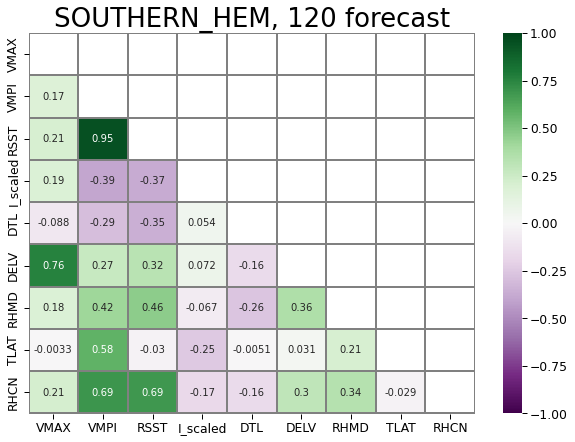

In [16]:
boo = foox.reset_index()[['VMAX','VMPI','RSST','I_scaled','DTL','DELV','RHMD','TLAT','RHCN']].corr()
mask = np.zeros_like(boo)
mask[np.triu_indices_from(mask)] = True
fig2,ax2 = plt.subplots(1,1,figsize=(10,7))
sns.heatmap(data=boo,mask=mask,cmap='PRGn',linewidths=2,linecolor='gray',
            annot=True, annot_kws={"size": 10},ax=ax2,vmin=-1,vmax=1)
ax2.set_title('{basin_sel}, {nhr} forecast'.format(basin_sel=basin_sel,nhr=nhr),fontsize=26)
f2_savename = 'predictors_corrcoef_{basin_sel}_{nhr}_fore'.format(basin_sel=basin_sel,nhr=nhr)
#foox.columns[0:50]
## 
